# Comparing Experimental Protocols on the ExtraSensory data set

## Set up the Notebook

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys, os
sys.path.insert(0, os.path.abspath('..'))
os.chdir(os.path.abspath('..'))

## Import modules

In [3]:
from Blocks.data_loader import extrasensory_data_loader
from Blocks.filter import MisingLabelFilter,  MisingDataColumnFilter, Take
from Blocks.imputer import Imputer
from Blocks.normalizer import Normalizer
from Blocks.experimental_protocol import ExpTrainTest, ExpCV, ExpWithin
from Blocks.results_analysis import ResultsConcat, ResultsCVSummarize, DataYieldReport

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.dummy import DummyClassifier

import matplotlib.pyplot as plt

from Workflow.workflow import workflow
import Workflow.compute_graph
import time
import pandas as pd


## Define the workflow

This workflow compare the performance estimates produced using two different experimental variations: train/test splits at the instance and the  individual levels.  

The model used is logistic regression with a fixed regularization hyper-parameter. The workflow includes a column filter that screens out feature dimensions that are less than 20% observed, a missing label filter that removes instances without labels, imputation, and feature normalization. Data pre-processing is shared across the two branches of the workflow.

In this experiment, we can see that when the data set is split at the individual level, the accuracy is 5% lower and the F1 score is more than 10% lower when compared to splitting at the instance level. This shows that splitting at the instance level can significantly and artificially improve results due to the weaker form of generalization that this protocol assesses. 

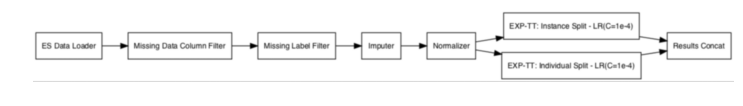

Running step ES Data Loader
  Loading Extrasensory pkl file...

Running step Missing Data Column Filter

Running step Missing Label Filter

Running step Imputer
  Imputer: Running on matrix of size 285268x224

Running step Normalizer
  Normalizer: running matrix of size 285268x224

Running step EXP-TT: Individual Split - LR(C=1e-4)
  Fitting and testing Individual Split - LR(C=1e-4)

Running step EXP-TT: Instance Split - LR(C=1e-4)
  Fitting and testing Instance Split - LR(C=1e-4)

Running step Results Concat
  Concatenating Results


,accuracy_score,f1_score,precision_score,recall_score
Instance Split - LR(C=1e-4),0.907824,0.838577,0.851143,0.826376
Individual Split - LR(C=1e-4),0.861211,0.714755,0.832555,0.626158



  Workflow complete



In [5]:
metrics     = [accuracy_score, f1_score, precision_score, recall_score]

df_raw      = extrasensory_data_loader(label="SLEEPING");
df_cf       = MisingDataColumnFilter(df_raw);
df_lf       = MisingLabelFilter(df_cf);
df_imp      = Imputer(df_lf, method="mean")
df_norm     = Normalizer(df_imp)

models = {"Instance Split - LR(C=1e-4)": LogisticRegression(solver="lbfgs",max_iter=100)}
res_inst = ExpTrainTest(df_norm, models, metrics=metrics, grouped=False);

models = {"Individual Split - LR(C=1e-4)": LogisticRegression(solver="lbfgs",max_iter=100)}
res_ind = ExpTrainTest(df_norm, models, metrics=metrics, grouped=True);

res_cat = ResultsConcat(res_inst, res_ind)
flow    = workflow(res_cat)
 
flow.draw(); plt.show();
output=flow.run();